# Introduction

This is a 'notebook' in Google Colaboratory. It contains a mixture of programming code (in Python), interspersed with comments and descriptions, to explain what's going on.

It's a 'live' notebook. That is, you can execute the code contained in the notebook by clicking the play button (triangle inside a circle) next to any of the code cells. You can also edit and change the code before you run it, or you can run it, change it, then run it again to see the changes. It's a good way to experiment with code.

You don't really need to know Python coding to use this notebook. In the simplest case you can just run the supplied code and it should work. But if you do know Python, or you want to experiment, you are welcome to.


To save your own copy of this notebook, you'll need to save it into Google Drive (or GitHub).

This example works through a very simple case of **ETL** - Extract, Transform, Load.

# Extract

The first thing we are going to do is to extract some data from your MongoDB Atlas cluster.

### Import various Python libraries we will need



In [ ]:
# Although PyMongo is already included in Colab, you need the `srv` extra to connect to Atlas:
!pip install --upgrade pymongo[srv]

from datetime import datetime, timedelta

from bson import ObjectId
import pymongo
from pymongo import MongoClient
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Connect to MongoDB Atlas

**In the line below, you can replace the value of MONGODB_URL (the bit inside the quotes) with the one that links to your own MongoDB Atlas database!**

In [ ]:
MONGODB_URL = "mongodb+srv://anushamadan02:<<password>>@cluster0.zrypgiq.mongodb.net/?retryWrites=true&w=majority"

client = MongoClient(MONGODB_URL)
client.list_database_names()

['Salary_Predictions', 'admin', 'local']

In [ ]:
# Choose a database, and list the collections in that database
db = client.get_database("Salary_Predictions")
db.list_collection_names()

['django_migrations', 'salary_data_salary_data', '__schema__']

In [ ]:
# Choose a collection
salary_data = db.get_collection("salary_data_salary_data")

### Run a query and store results in a Pandas DataFrame

In [ ]:
results = salary_data.find()

# We need to do some type manipulation - convert our Cursor of results into a list, then convert the list into a Pandas DataFrame
results_list = list(results)
df = pd.DataFrame(results_list)

# Print out the first few rows of the DataFrame
df.head()

,_id,Id,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,63808d4db5717040c1455c1b,1,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,...,72,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,63808d4db5717040c1455c1d,3,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,...,85,KnowBe4\n,FL,1,10,1,0,1,0,1
2,63808d4db5717040c1455c1e,4,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
3,63808d4db5717040c1455c1f,5,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1
4,63808d4db5717040c1455c20,6,Data Scientist,$71K-$119K (Glassdoor est.),CyrusOne is seeking a talented Data Scientist ...,3.4,CyrusOne\n3.4,"Dallas, TX","Dallas, TX",201 to 500 employees,...,95,CyrusOne\n,TX,1,20,1,0,0,1,1


In [ ]:
# Show total number of documents in the collection
print (len(df))

742


### Explore the data a little bit

In [ ]:
# Count the number of documents in each job title
df['job_title'].value_counts()

Data Scientist                          131
Data Engineer                            53
Senior Data Scientist                    34
Data Analyst                             15
Senior Data Engineer                     14
                                       ... 
SQL Data Engineer                         1
Junior Data Analyst                       1
Lead Health Data Analyst - Front End      1
Survey Data Analyst                       1
Data Scientist2                           1
Name: job_title, Length: 264, dtype: int64

In [ ]:
# Count the number of documents for availability of the different python skills
df['python_yn'].value_counts()

1    392
0    350
Name: python_yn, dtype: int64

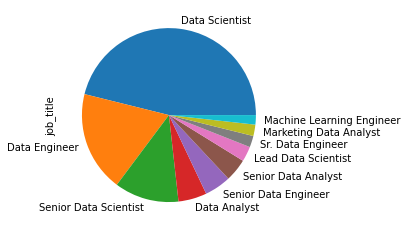

In [ ]:
# Just for fun we can even create a little bar chart and visualise the number of types of jobs
temp= df['job_title'].value_counts()
temp.head(10).plot(kind='pie');

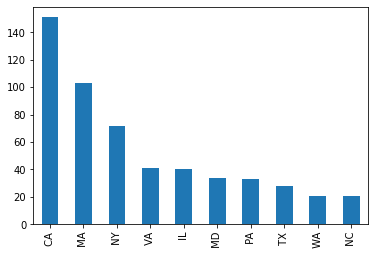

In [ ]:
# Just for fun we can even create a little bar chart and visualise the number of jobs available in each state
temp= df['job_state'].value_counts()
temp.head(10).plot(kind='bar');

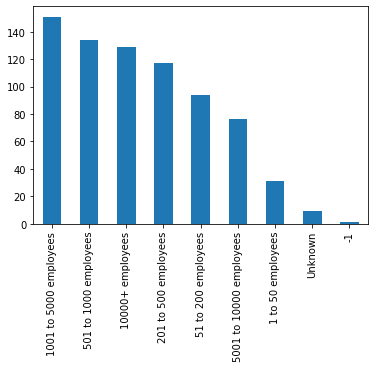

In [ ]:
# Just for fun we can even create a little bar chart and visualise the size ranges of the different jobs
df['size'].value_counts().plot(kind='bar');

# Transform

Now that we've extracted the data and had a bit of a look at it, we can apply some transformations. Note that we're processing the data as a batch here, not streaming transformation.

### Deal with missing values

We noticed above that some documents have '-1' or 'Unknown' as the size. When cleaning/transforming the data, we need to decide what to do with them. We could:
* remove those rows entirely
* change 'Missing' to some other value

If it was numeric data we could consider taking the mean or median value, but as it's a text field that's not applicable.

Let's say that we want our data warehouse to only have clean data, so we'll just remove those rows entirely from the data set.

In [ ]:
# We'll create a new DataFrame called transformed that consists of all documents from the original set where the size is not -1 or Unknown
df['size'].value_counts()

1001 to 5000 employees     151
501 to 1000 employees      134
10000+ employees           129
201 to 500 employees       117
51 to 200 employees         94
5001 to 10000 employees     76
1 to 50 employees           31
Unknown                      9
-1                           1
Name: size, dtype: int64

In [ ]:
# We'll create a new DataFrame called transformed that consists of all documents from the original set where the size is not -1 or Unknown
transformed = df[(df['size'] != "Unknown") & (df['size'] != "-1")].copy()

In [ ]:
# To verify this, let's count the number of documents for each size again. There shouldn't be any -1 or Unknown
transformed['size'].value_counts()

1001 to 5000 employees     151
501 to 1000 employees      134
10000+ employees           129
201 to 500 employees       117
51 to 200 employees         94
5001 to 10000 employees     76
1 to 50 employees           31
Name: size, dtype: int64

### Rewrite values

Maybe the data we are importing doesn't match the data model used in our data warehouse. We might need to transform or change some of the values in the input data so that it matches what we want it to be.

Let's look at all the possible (unique) job titles types

In [ ]:
print (df['job_title'].unique())

['Data Scientist' 'Research Scientist' 'Staff Data Scientist - Technology'
 'Data Analyst' 'Data Engineer I' 'Scientist I/II, Biology'
 'Customer Data Scientist' 'Data Scientist - Health Data Analytics'
 'Senior Data Scientist / Machine Learning'
 'Data Scientist - Quantitative' 'Digital Health Data Scientist'
 'Associate Data Analyst' 'Clinical Data Scientist'
 'Data Scientist / Machine Learning Expert' 'Web Data Analyst'
 'Senior Data Scientist' 'Data Engineer'
 'Data Scientist - Algorithms & Inference' 'Scientist'
 'Lead Data Scientist' 'Spectral Scientist/Engineer'
 'College Hire - Data Scientist - Open to December 2019 Graduates'
 'Data Scientist, Office of Data Science' 'Data Science Analyst'
 'Senior Risk Data Scientist'
 'Data Scientist in Artificial Intelligence Early Career'
 'Data Scientist - Research' 'R&D Data Analysis Scientist'
 'Analytics Consultant' 'Director, Data Science' 'Data Scientist SR'
 'R&D Sr Data Scientist' 'Customer Data Scientist/Sales Engineer (Bay'
 'Jr.

In [ ]:
df['job_title'].nunique()

264

There's some data quality issues in there. 
The fact that there's two different terms representing the same thing is a problem. It's also a bit cumbersome if you wanted to query the data.


In [ ]:

transformed.loc[df['job_title'].str.contains('Data Scientist'), 'job_title'] = 'Data Scientist'
transformed.loc[df['job_title'].str.contains('Data Engineer'), 'job_title'] = 'Data Engineer'
transformed.loc[df['job_title'].str.contains('Software Engineer'), 'job_title'] = 'Software Engineer'
transformed.loc[df['job_title'].str.contains('Research Scientist'), 'job_title'] = 'Research Scientist'
transformed.loc[df['job_title'].str.contains('Director'), 'job_title'] = 'Director'
transformed.loc[df['job_title'].str.contains('Data Analyst'), 'job_title'] = 'Data Analyst'
transformed.loc[df['job_title'].str.contains('Machine Learning Engineer'), 'job_title'] = 'Machine Learning Engineer'
transformed.loc[df['job_title'].str.contains('Associate Scientist'), 'job_title'] = 'Associate Scientist'
transformed.loc[df['job_title'].str.contains('Developer'), 'job_title'] = 'Developer'
transformed.loc[df['job_title'].str.contains('Manager'), 'job_title'] = 'Manager'
transformed.loc[df['job_title'].str.contains('Architect'), 'job_title'] = 'Architect'
transformed['job_title'].nunique()


89

In [ ]:
# To verify this, let's count the number of documents for each job title type again.
transformed['job_title'].value_counts()

Data Scientist                                          266
Data Engineer                                           112
Data Analyst                                             99
Manager                                                  25
Research Scientist                                       17
                                                       ... 
Senior Spark Engineer (Data Science)                      1
Medical Technologist / Clinical Laboratory Scientist      1
Data & Analytics Consultant (NYC)                         1
CONSULTANT– DATA ANALYTICS GROUP                          1
Scientist - CVRM Metabolism - in vivo pharmacology        1
Name: job_title, Length: 89, dtype: int64

### Select columns

Maybe we don't want to load all columns from the original data into our data warehouse.

The original data contains a column called 'grades'. Let's delete this column entirely.

In [ ]:
# Delete the 'grades' column
del transformed['job_description']

In [ ]:
# Print out the first few rows again, just so we can see that column is gone now
transformed.head()

,_id,Id,job_title,salary_estimate,rating,company_name,location,headquarters,size,founded,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,63808d4db5717040c1455c1b,1,Data Scientist,$53K-$91K (Glassdoor est.),3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,72,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,63808d4db5717040c1455c1d,3,Data Scientist,$80K-$90K (Glassdoor est.),4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,85,KnowBe4\n,FL,1,10,1,0,1,0,1
2,63808d4db5717040c1455c1e,4,Data Scientist,$56K-$97K (Glassdoor est.),3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,76.5,PNNL\n,WA,1,55,1,0,0,0,0
3,63808d4db5717040c1455c1f,5,Data Scientist,$86K-$143K (Glassdoor est.),2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1
4,63808d4db5717040c1455c20,6,Data Scientist,$71K-$119K (Glassdoor est.),3.4,CyrusOne\n3.4,"Dallas, TX","Dallas, TX",201 to 500 employees,2000,...,95,CyrusOne\n,TX,1,20,1,0,0,1,1


# Load

Now that we've extracted our data and transformed it, it's time to load it.

In this example, for simplicity we'll just load it back into the same MongoDB Atlas database that we extracted it from, but put it into a new collection.

Normally of course you would load it into a different database.

In [ ]:
# Create a new collection in the database. Note that with MongoDB the collection doesn't actually exist until we put some data into it (next step)
# Our new collection will be called "new_salary_data"
newcollection = db["new_salary_data"]

In [ ]:
# Just in case the new collection has data in it (because we re-ran this notebook several times), let's delete all documents in it.
delete_result = newcollection.delete_many({})
print(delete_result.deleted_count, " documents deleted.")


0  documents deleted.


In [ ]:
# Insert the records (documents) from our 'transformed' Pandas DataFrame into the new collection
# Note that if you try to run this twice without first deleting all the documents, you will get an error about inserting duplicates. That's OK, just delete them (previous code block) first
insert_result = newcollection.insert_many(transformed.to_dict('records'))
if insert_result.acknowledged:
  print ("Insert successful")


Insert successful


Now log in to your MongoDB Atlas cluster, and look at your list of databases and collections.

In the 'restaurants' database, there should now be another collection called 'new_restaurants'.

How many documents are in the new collection compared with the original one?

Verify that there is no 'grades' attribute in the new collection either.

# Summary

We've just seen a very simple ETL example where we extracted some data from a database, applied some transformations, then loaded it back into another database.

The purpose is just to illustrate at a very basic level how a data engineer might create code that implements batch ETL processing on data. If you don't know Python code and didn't really understand the code, that's fine - it's more about understanding the steps, and being able to try them out.

Even if you don't know Python though, one thing you might have noticed along the way is that most steps only required 1 or 2 lines of code. We could transform an entire data set with a single instruction. That's the power of ETL - being able to automate data pipelines with simple instructions.